In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/cse455/birds/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Mounted at /content/drive


In [ ]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Use the mean and std of ImageNet
    ])
    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Use the mean and std of ImageNet
    ])
    torch.manual_seed(904)
    train_image_set = torchvision.datasets.ImageFolder(root='drive/MyDrive/cse455/birds/train', transform=transform_train)
    trainset_size = (int)(len(train_image_set) * 0.85)
    validset_size = len(train_image_set) - trainset_size
    trainset, validset = torch.utils.data.random_split(train_image_set, [trainset_size, validset_size])
    print(len(train_image_set))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4) # batch = 64?
    validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=False, num_workers=4) # batch = 64?
    testset = torchvision.datasets.ImageFolder(root='drive/MyDrive/cse455/birds/test', transform=transform_test)
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("drive/MyDrive/cse455/birds/names.txt").read().strip().split("\n")
    class_to_idx = train_image_set.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'valid' : validloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

38562


In [ ]:
print(data['to_class'])
print(data['to_name'])
!ls

{0: 0, 1: 1, 2: 10, 3: 100, 4: 101, 5: 102, 6: 103, 7: 104, 8: 105, 9: 106, 10: 107, 11: 108, 12: 109, 13: 11, 14: 110, 15: 111, 16: 112, 17: 113, 18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 12, 25: 120, 26: 121, 27: 122, 28: 123, 29: 124, 30: 125, 31: 126, 32: 127, 33: 128, 34: 129, 35: 13, 36: 130, 37: 131, 38: 132, 39: 133, 40: 134, 41: 135, 42: 136, 43: 137, 44: 138, 45: 139, 46: 14, 47: 140, 48: 141, 49: 142, 50: 143, 51: 144, 52: 145, 53: 146, 54: 147, 55: 148, 56: 149, 57: 15, 58: 150, 59: 151, 60: 152, 61: 153, 62: 154, 63: 155, 64: 156, 65: 157, 66: 158, 67: 159, 68: 16, 69: 160, 70: 161, 71: 162, 72: 163, 73: 164, 74: 165, 75: 166, 76: 167, 77: 168, 78: 169, 79: 17, 80: 170, 81: 171, 82: 172, 83: 173, 84: 174, 85: 175, 86: 176, 87: 177, 88: 178, 89: 179, 90: 18, 91: 180, 92: 181, 93: 182, 94: 183, 95: 184, 96: 185, 97: 186, 98: 187, 99: 188, 100: 189, 101: 19, 102: 190, 103: 191, 104: 192, 105: 193, 106: 194, 107: 195, 108: 196, 109: 197, 110: 198, 111: 199, 112

In [ ]:
print(len(data['to_name']))

555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 224, 224])


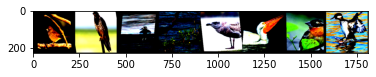

Labels:Green-tailed Towhee, Swainson's Hawk (Light morph ), White-winged Scoter (Female/juvenile), Little Blue Heron (Adult), Glaucous-winged Gull (Immature), American White Pelican, Black-headed Grosbeak (Female/immature male), Bufflehead (Female/immature male)


In [ ]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

In [ ]:
def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

In [ ]:
# Train with valid loss (not completed)
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    valid_losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']
        valid_losses = state['valid_losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0
        sum_valid_loss = 0.0
        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]
        # Training Loss
        for i, batch in enumerate(dataloader['train'], 0):
          net.train()
          inputs, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          
          optimizer.zero_grad()
          loss.backward()  # autograd magic, computes all the partial derivatives
          optimizer.step() # takes a step in gradient direction
          losses.append(loss.item())
          sum_loss += loss.item()
          if i % print_every == print_every-1:    # print every 10 mini-batches
              if verbose:
                print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
              sum_loss = 0.0
        # Testing Loss
        for i, batch in enumerate(dataloader['valid'], 0):
          with torch.no_grad():
            net.eval()
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
    
            valid_losses.append(loss.item())
            sum_valid_loss += loss.item()
            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] valid loss: %.3f' % (epoch, i + 1, sum_valid_loss / print_every))
                sum_valid_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses, 'valid_losses':valid_losses}
            torch.save(state, checkpoint_path + 'val-checkpoint-%d.pkl'%(epoch+1))
    return losses, valid_losses

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 555) # This will reinitialize the layer as well
losses, valid_losses = train(resnet, data, epochs=25, schedule={0:.01, 5:.001, 10:.0001, 15: .00001, 20: .000001}, lr=0.01, print_every=10, checkpoint_path=checkpoints, state=state)

## Get accuracy at every checkpoint


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
[0.3661714006773042, 0.4292644232236019, 0.5102053269060621, 0.5446197028404064, 0.5523995484638619, 0.7373463099124385, 0.7492143881380237, 0.7580315465112731, 0.7642249138115141, 0.7753607712725387, 0.7775574335662202, 0.7793574762790981, 0.7870152851084602, 0.7854593159837691, 0.782530432925527, 0.7839338560576014, 0.7832626536900875, 0.7839948744546481, 0.7882661622479178, 0.785703389571956, 0.7849101504103487, 0.7828355249107606, 0.781401592580163, 0.7842999664398816, 0.7850626964029654]
[0.3481417458945549, 0.39377700950734656, 0.4515125324114088, 0.4788245462402766, 0.4964563526361279, 0.6442523768366465, 0.651685393258427, 0.6651685393258427, 0.6708729472774416, 0.6679343128781331, 0.6833189282627485, 0.6807260155574762, 0.6814174589455488, 0.6847018150388937, 0.6879861711322386, 0.6867761452031115, 0.6798617113223855, 0.6803802938634399, 0.6762316335350044, 0.6814174589455488, 0.6869490060501297, 0.67986171132238

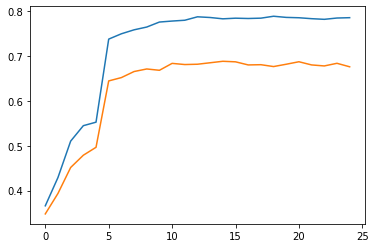

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 555) # This will reinitialize the layer as well
test_accu = []
valid_accu = []
for i in range(25):
  print(i)
  state = torch.load(checkpoints + 'val-checkpoint-{}.pkl'.format(i+1))
  resnet.load_state_dict(state['net'])
  test_accu.append(accuracy(resnet, data['train']))
  valid_accu.append(accuracy(resnet, data['valid']))
plt.plot(test_accu)
plt.plot(valid_accu)
print(test_accu)
print(valid_accu)

Text(0, 0.5, 'Accuracy')

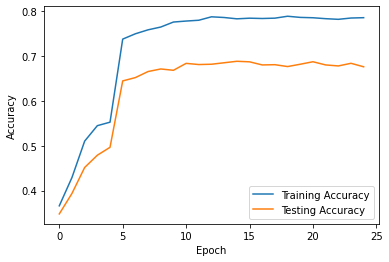

In [ ]:
plt.plot(test_accu, label="Training Accuracy")
plt.plot(valid_accu, label="Testing Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

2251
12776


Text(0, 0.5, 'Loss')

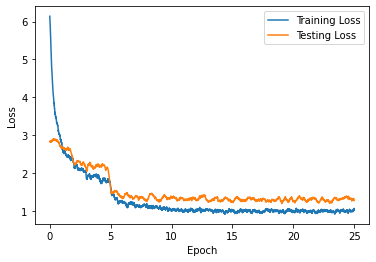

In [ ]:
# state = torch.load(checkpoints + 'checkpoint-20.pkl')
x1 = np.linspace(0, 25, 12776)
x2 = np.linspace(0, 25, 2251)

print(len(smooth(state['valid_losses'], 25)))
print(len(smooth(state['losses'], 50)))
plt.plot(x1, smooth(state['losses'], 50), label="Training Loss")
plt.plot(x2, smooth(state['valid_losses'], 25), label="Testing Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Create a prediction csv file for kaggle competition

In [ ]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [ ]:
predict(resnet, data['test'], checkpoints + "preds.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
